In [1]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

### Model preparation

In [192]:
dataset=pd.read_csv('all_moddataset.csv')

y=dataset['price_log']

t=dataset.columns.tolist()
t.remove('kod')
t.remove('price')
t.remove('price_log')
t.remove('Id')
t.remove('index')
t.remove('Unnamed: 0')
t.remove('clock')


car_features=t

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X=dataset[car_features]
train_X, val_X, train_y, val_y =train_test_split(X,y, random_state=42,test_size=0.05)

mae_compare = pd.Series()
mae_compare.index.name = 'Algorithm'


In [191]:
val_X.head()

,fullweight,gearsize,power,selfweight,status,travel,year,name0_FORD,name0_HONDA,name0_MITSUBISHI,...,name0_SUZUKI,fuel_Benzin,fuel_Benzin/Gáz,fuel_Dízel,fuel_Egyéb,fuel_Hibrid (Benzin),age,load,ca,clock_log
3265,2140.0,2204.0,105,1631.0,4,5.0,14.0,0,1,0,...,0,0,0,1,0,0,14.0,509.0,10892.0,12.567237
23387,1530.0,1242.0,60,1055.0,7,5.0,2.0,1,0,0,...,0,1,0,0,0,0,2.0,475.0,9832.0,10.815770
14115,1565.0,1248.0,55,1070.0,4,5.0,11.0,0,0,0,...,0,0,0,1,0,0,11.0,495.0,11232.0,11.997756
12223,1935.0,1686.0,75,1380.0,6,5.0,15.0,0,0,0,...,0,0,0,1,0,0,15.0,555.0,12645.0,12.429216
22099,1740.0,1596.0,85,1257.0,6,5.0,10.0,1,0,0,...,0,1,0,0,0,0,10.0,483.0,9069.0,11.878728


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 60, num = 25)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [ 2, 4],
    'min_samples_split': [5, 10],
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 300, num = 50)]
}
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


grid_search.fit(train_X, train_y)

grid_search.best_params_

In [8]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [187]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

def inv_y(transformed_y):
    return np.exp(transformed_y)


rf_model = RandomForestRegressor(n_estimators=351,min_samples_split=4, 
                                 min_samples_leaf=4, max_features=4, 
                                 max_depth=30,bootstrap=False,verbose=1)
rf_model.fit(train_X, train_y)
rf_preds = rf_model.predict(val_X)
rf_mae = mean_absolute_error(inv_y(rf_preds), inv_y(val_y))
rf_mae2 = explained_variance_score(inv_y(rf_preds), inv_y(val_y))

mae_compare['RandomForest'] = rf_mae
rf_test=rf_preds
pickle.dump(rf_model.fit(train_X,train_y), open("rf_model.mod", 'wb'))
pickle.dump(rf_test, open("rf_test.t", 'wb'))
pickle.dump(val_y, open("val_y.t", 'wb'))
pickle.dump(val_X, open("val_X.t", 'wb'))
print('[OK] RandomForest')

mae_compare


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:    9.8s finished


[OK] RandomForest


Algorithm
RandomForest    188549.548191
dtype: float64

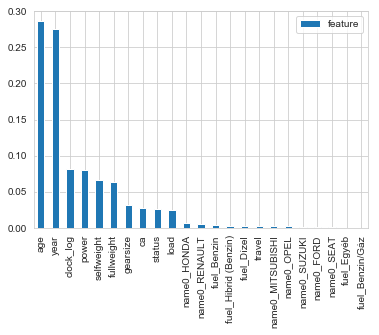

In [188]:
result=pd.DataFrame(rf_model.feature_importances_, X.columns).head(30)
result.columns=['feature']
result.sort_values(by='feature', ascending=False).plot(kind='bar')

In [22]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print(evaluate(rf_model,val_X,val_y))

Model Performance
Average Error: 0.1581 degrees.
Accuracy = 98.84%.
98.84185411691237


In [10]:
def search_grid_RF(train_X,train_y,val_X,val_y):
    l=[]
    start_time=datetime.datetime.now()
    for nest in range(1,400,50):
        for mss in range(2,10,2):
            for msl in range(2,10,2):
                d={}
                test_model = RandomForestRegressor(n_estimators=nest,min_samples_split=mss, min_samples_leaf=msl)
                test_model.fit(train_X, train_y)
                test_pred=test_model.predict(val_X)
                test_mae='{:1.0f}'.format(mean_absolute_error(inv_y(test_pred), inv_y(val_y)))
                d['N_est']=nest
                d['Mss']=mss
                d['Msl']=mss
                d['MAE']=test_mae
                l.append(d)
        print(nest)
    tt=pd.DataFrame(l)
    tt = tt.astype({"MAE":'int64'})
    end_time=datetime.datetime.now()
    print(end_time-start_time)
    return tt


def search_grid_GB(train_X,train_y,val_X,val_y):
    l=[]
    start_time=datetime.datetime.now()
    for nest in range(150,150,1):
        for lr in range(1,10,1):
            for md in range(1,10,1):
                d={}
                test_model = GradientBoostingRegressor(n_estimators=32, learning_rate=0.1, 
                                      max_depth=md)
                test_model.fit(train_X, train_y)
                test_pred=test_model.predict(val_X)
                test_mae='{:1.0f}'.format(mean_absolute_error(inv_y(test_pred), inv_y(val_y)))
                d['N_est']=nest
                d['Mss']=lr
                d['Msl']=md
                d['MAE']=test_mae
                l.append(d)
        print(nest)
    tt=pd.DataFrame(l)
    tt = tt.astype({"MAE":'int64'})
    end_time=datetime.datetime.now()
    print(end_time-start_time)
    return tt

In [ ]:
tt=search_grid_RF(train_X,train_y, val_X, val_y)



In [ ]:
sns.lineplot(x="N_est", y="MAE",data=tt)

In [ ]:
tt.sort_values(by='MAE').head()